# Analyze OME-Zarr for illumination bias
Notebook to process OME-Zarr files generated by Fractal to measure illumination biases

If measurements were made per FOV (using the FOV_ROI_table), this notebook should just run. Otherwise, use a modulo calculation witht he image size to mape back the coordinates to coordinates in a FOV (if imaged in a grid)

path needs to be the path to a AnnData table in a given well

In [1]:
import anndata as ad
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path

In [31]:
def calculate_mean_per_bin(df, feature = 'mean_intensity', nb_bins = 20, img_dims_x = 2560, img_dims_y = 2160):
    df_average_intensity = pd.DataFrame()

    start_y = 0
    for y in range(nb_bins):
        start_x = 0
        for x in range(nb_bins):
            window_x = int(img_dims_x / nb_bins)
            window_y = int(img_dims_y / nb_bins)
            mean_value = df[(df['centroid-2'] > start_x) & 
               (df['centroid-2'] < start_x + window_x) & 
               (df['centroid-1'] > start_y) & 
               (df['centroid-1'] < start_y + window_y)][feature].mean()
            new_entry = pd.DataFrame([[start_x + window_x/2, -(start_y + window_y/2), mean_value]], columns = ['X_center', 'Y_center', f'Mean_{feature}'])
            df_average_intensity = pd.concat([df_average_intensity, new_entry])
            start_x += window_x
        start_y += window_y

    return df_average_intensity

def plot_illum_corr(df_average_intensity, title, hue_norm=None, colormap="viridis"):
    std_bins = df_average_intensity['Mean_mean_intensity'].std()
    plt.figure()
    ax = sns.scatterplot(
        data=df_average_intensity, 
        x='X_center', 
        y='Y_center', 
        hue='Mean_mean_intensity',
        hue_norm=hue_norm,
        palette=colormap,
        s=150,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = ax.figure.suptitle(f"{title}, std: {std_bins:.2f}")

In [ ]:
#path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_with_illum_corr_v1/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
channel = 'Channel1'
well = 'E/05'

basepath_no = Path(f"/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/no_illum_coor_nicole-60x-2/AssayPlate_Greiner_#655090.zarr/{well}/0/tables/")
basepath_with = Path(f"/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/nicole_illumcorr-60x-2/AssayPlate_Greiner_#655090.zarr/{well}/0/tables/")

adata_no_illum_corr = ad.read_zarr(basepath_no / channel)
df_no_illum_corr = adata_no_illum_corr.to_df()

adata_with_illum_corr = ad.read_zarr(basepath_with / channel)
df_with_illum_corr = adata_with_illum_corr.to_df()

/Users/joel/opt/miniconda3/envs/napari-ome-zarr/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/joel/opt/miniconda3/envs/napari-ome-zarr/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Plot with diverging colormaps

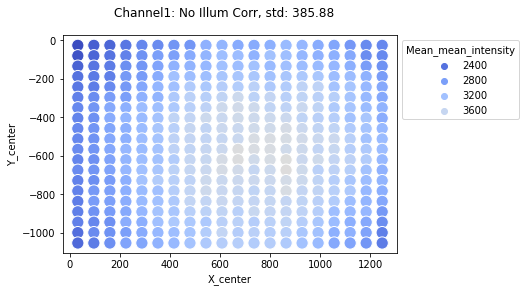

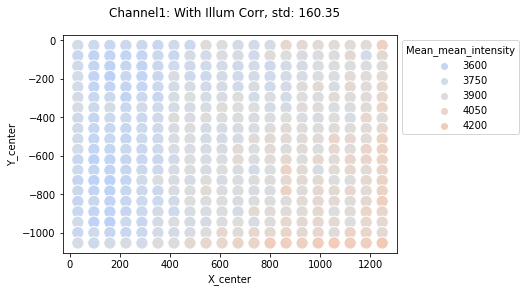

In [58]:
# Center the max value of the non-corrected image in the colormap
feature = 'mean_intensity'
df_average_intensity_no = calculate_mean_per_bin(df_no_illum_corr, feature, img_dims_x = 1280, img_dims_y = 1080)
df_average_intensity_with = calculate_mean_per_bin(df_with_illum_corr, feature, img_dims_x = 1280, img_dims_y = 1080)

min_val = min(min(df_average_intensity_with['Mean_mean_intensity']), min(df_average_intensity_no['Mean_mean_intensity']))
#max_val = max(max(df_average_intensity_with['Mean_mean_intensity']), max(df_average_intensity_no['Mean_mean_intensity']))
max_val = 2 * max(df_average_intensity_no['Mean_mean_intensity']) - min(df_average_intensity_no['Mean_mean_intensity'])
colormap = sns.color_palette("coolwarm", as_cmap=True)

plot_illum_corr(df_average_intensity_no, title=channel + ": No Illum Corr", hue_norm = (min_val, max_val), colormap=colormap)
plot_illum_corr(df_average_intensity_with, title=channel + ": With Illum Corr", hue_norm = (min_val, max_val), colormap=colormap)

### Create plots selected colormap

In [ ]:
feature = 'mean_intensity'
df_average_intensity_no = calculate_mean_per_bin(df_no_illum_corr, feature, img_dims_x = 1280, img_dims_y = 1080)
df_average_intensity_with = calculate_mean_per_bin(df_with_illum_corr, feature, img_dims_x = 1280, img_dims_y = 1080)

min_val = min(min(df_average_intensity_with['Mean_mean_intensity']), min(df_average_intensity_no['Mean_mean_intensity']))
max_val = max(max(df_average_intensity_with['Mean_mean_intensity']), max(df_average_intensity_no['Mean_mean_intensity']))

colormap = "viridis"

plot_illum_corr(df_average_intensity_no, title=channel + ": No Illum Corr", hue_norm = (min_val, max_val), colormap=colormap)
plot_illum_corr(df_average_intensity_with, title=channel + ": With Illum Corr", hue_norm = (min_val, max_val), colormap=colormap)